In [95]:
import pandas as pd
import numpy as np
from sklearn.impute import *

train = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/train.csv')
test = pd.read_csv('/kaggle/input/tabular-playground-series-apr-2021/test.csv')
y = train.Survived

print(np.sum(train.PassengerId == test.PassengerId))

train.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

train.head()

0


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,male,NaN,2,0,27.14,C12239,S
1,3,male,NaN,0,0,13.35,NaN,S
2,3,male,0.33,1,2,71.29,NaN,S
3,3,male,19.00,0,0,13.04,NaN,S
4,3,male,25.00,0,0,7.76,NaN,S


In [96]:
target_column = 'Age'
train[train[target_column].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96708 entries, 2 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    96708 non-null  int64  
 1   Sex       96708 non-null  object 
 2   Age       96708 non-null  float64
 3   SibSp     96708 non-null  int64  
 4   Parch     96708 non-null  int64  
 5   Fare      96579 non-null  float64
 6   Cabin     31089 non-null  object 
 7   Embarked  96460 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 6.6+ MB


In [97]:
columns_to_fit = []
for key in train.keys():
    if key == target_column: continue
    if train[target_column].notnull().sum() == train[train[target_column].notnull()][key].notnull().sum():
        columns_to_fit.append(key)

columns_to_fit

['Pclass', 'Sex', 'SibSp', 'Parch']

In [98]:
not_append, to_append = [], []
for column in columns_to_fit:
    if train[column].dtype == np.float64:
        not_append.append(column)
    else:
        to_append.append(column)
print(not_append)
print(to_append)

[]
['Pclass', 'Sex', 'SibSp', 'Parch']


In [99]:
from sklearn.preprocessing import *

onehotencoder = OneHotEncoder()
categorical = train[train[target_column].notnull()][to_append]
X = onehotencoder.fit_transform(categorical).toarray()

In [100]:
X

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [101]:
X = np.concatenate((X, train[train[target_column].notnull()][not_append]), axis=1)

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, accuracy_score

model = DecisionTreeRegressor()
# model = LinearRegression()
model.fit(X, train[train[target_column].notnull()][target_column])
yp = model.predict(X)

print(mean_squared_error(yp, train[train[target_column].notnull()][target_column]))

279.80903767909723


In [103]:
# Xt = onehotencoder.transform(train[train[target_column].isnull()][to_append]).toarray()
# Xt = np.concatenate((Xt, train[train[target_column].isnull()][not_append]), axis=1)

# ypt = model.predict(Xt)

Xt = onehotencoder.transform(train[to_append]).toarray()
Xt = np.concatenate((Xt, train[not_append]), axis=1)

ypt = model.predict(Xt)

In [104]:
result = train[target_column].isnull() * ypt

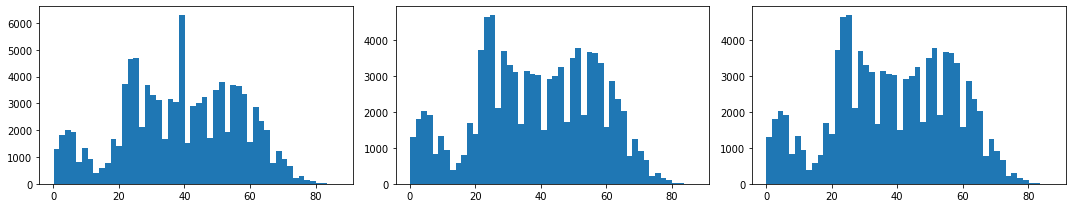

In [105]:
import matplotlib.pyplot as plt

imputer = SimpleImputer(missing_values=np.nan, strategy = 'mean')
imputer = imputer.fit(train[['Age']])
imputed_mean = imputer.transform(train[['Age']])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

axes[0].hist(imputed_mean, bins=50)
axes[1].hist(train["Age"], bins=50)
axes[2].hist(train[target_column] + result, bins=50)

fig.tight_layout()

#Age clearly has three age distributions, putting the average or median in place of 
#nan may not be the best strategy
#I'll separate into categories during training
#What to put in place of NAN? 
#forms of imput missing values
#We will use Regression on the other features

In [106]:
train.fillna({target_column: 0}, inplace=True)
train[target_column] = train[target_column] + result

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import *

#Impute with regression from other features
def doMethodImpute(data, target_column, model=DecisionTreeRegressor):
    class doMethodImputeIntern():
        def __init__(self, target_column, not_append, to_append, onehotencoder, model):
            self.target_column = target_column
            self.not_append = not_append
            self.to_append = to_append
            self.onehotencoder = onehotencoder
            self.model = model

        def transform(self, new_data):
            Xt = self.onehotencoder.transform(new_data[self.to_append]).toarray()
            Xt = np.concatenate((Xt, new_data[self.not_append]), axis=1)
            ypt = self.model.predict(Xt)

            result = new_data[self.target_column].isnull() * ypt
            new_data.fillna({self.target_column: 0}, inplace=True)
            new_data[self.target_column] = new_data[self.target_column] + result
            return self

    columns_to_fit = []
    for key in data.keys():
        if key == target_column: continue
        if data[target_column].notnull().sum() == data[data[target_column].notnull()][key].notnull().sum():
            columns_to_fit.append(key)

    not_append, to_append = [], []
    for column in columns_to_fit:
        if data[column].dtype == np.float64:
            not_append.append(column)
        else:
            to_append.append(column)

    onehotencoder = OneHotEncoder()
    categorical = data[data[target_column].notnull()][to_append]
    X = onehotencoder.fit_transform(categorical).toarray()
    X = np.concatenate((X, data[data[target_column].notnull()][not_append]), axis=1)

    model = model()
    model.fit(X, data[data[target_column].notnull()][target_column])
    yp = model.predict(X)

    Xt = onehotencoder.transform(data[to_append]).toarray()
    Xt = np.concatenate((Xt, data[not_append]), axis=1)
    ypt = model.predict(Xt)

    result = data[target_column].isnull() * ypt
    data.fillna({target_column: 0}, inplace=True)
    data[target_column] = data[target_column] + result
    return doMethodImputeIntern(target_column, not_append, to_append, onehotencoder, model)

In [108]:
imputer = doMethodImpute(train, 'Age')
imputer.transform(test)

<__main__.doMethodImpute.<locals>.doMethodImputeIntern at 0x7f1351269e10>

In [109]:
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,male,40.956803,2,0,27.14,C12239,S
1,3,male,35.964280,0,0,13.35,NaN,S
2,3,male,0.330000,1,2,71.29,NaN,S
3,3,male,19.000000,0,0,13.04,NaN,S
4,3,male,25.000000,0,0,7.76,NaN,S


In [110]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,19.0,0,0,63.01,NaN,S
1,3,female,53.0,0,0,5.81,NaN,S
2,1,female,19.0,0,0,38.91,B15315,C
3,2,male,25.0,0,0,12.93,NaN,S
4,1,female,17.0,0,2,26.89,B22515,C


In [111]:
imputer = doMethodImpute(train, 'Fare')
imputer.transform(test)

<__main__.doMethodImpute.<locals>.doMethodImputeIntern at 0x7f1351cc4a50>

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Pclass    100000 non-null  int64  
 1   Sex       100000 non-null  object 
 2   Age       100000 non-null  float64
 3   SibSp     100000 non-null  int64  
 4   Parch     100000 non-null  int64  
 5   Fare      100000 non-null  float64
 6   Cabin     32134 non-null   object 
 7   Embarked  99750 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 6.1+ MB


In [113]:
# train['Age'].interpolate(method='linear', inplace=False, limit_direction="both")

<AxesSubplot:>

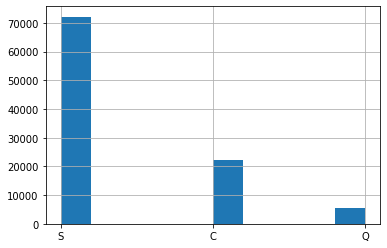

In [114]:
train['Embarked'].hist()

In [115]:
train.fillna({'Cabin': "NE"}, inplace=True)
test.fillna({'Cabin': "NE"}, inplace=True)

train.fillna({'Embarked': "NE"}, inplace=True)
test.fillna({'Embarked': "NE"}, inplace=True)

In [116]:
for data in [train, test]:
    cabins_vec = []
    for i in data['Cabin']:
        if str(i) == 'NE':
            cabins_vec.append("NE")
        else:
            cabins_vec.append(i[0])
    data['Cabin'] = pd.Series(cabins_vec)

In [117]:
for data in [train, test]:
    embk_vec = []
    for i in data['Embarked']:
        if str(i) == 'NE':
            embk_vec.append("NE")
        else:
            embk_vec.append(i)
    data['Embarked'] = pd.Series(embk_vec)

In [118]:
train['Cabin'], train['Embarked']

(0         C
 1        NE
 2        NE
 3        NE
 4        NE
          ..
 99995     D
 99996    NE
 99997    NE
 99998    NE
 99999    NE
 Name: Cabin, Length: 100000, dtype: object,
 0        S
 1        S
 2        S
 3        S
 4        S
         ..
 99995    C
 99996    S
 99997    S
 99998    S
 99999    S
 Name: Embarked, Length: 100000, dtype: object)

<AxesSubplot:>

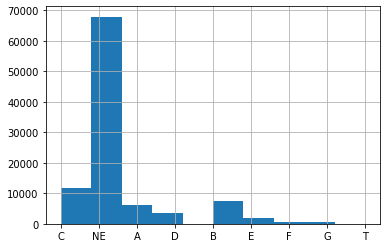

In [119]:
train['Cabin'].hist()

<AxesSubplot:>

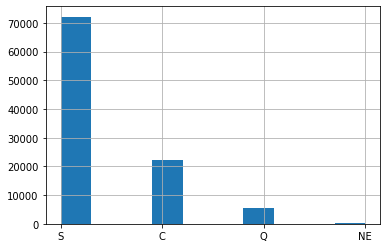

In [120]:
train['Embarked'].hist()

In [121]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Pclass    100000 non-null  int64  
 1   Sex       100000 non-null  object 
 2   Age       100000 non-null  float64
 3   SibSp     100000 non-null  int64  
 4   Parch     100000 non-null  int64  
 5   Fare      100000 non-null  float64
 6   Cabin     100000 non-null  object 
 7   Embarked  100000 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 6.1+ MB


In [122]:
## Other options for Impute
# train.fillna({'Cabin': 0}, inplace=True)
# test.fillna({'Cabin': 0}, inplace=True)

# imputer = SimpleImputer(missing_values=np.nan, strategy = 'mean')
# imputer = imputer.fit(train[['Age']])
# train[['Age']] = imputer.transform(train[['Age']])
# test[['Age']] = imputer.transform(test[['Age']])

# #usando a mediana porque Fare varia muito, é skew
# #log também ajuda a reduzir skewness
# imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')
# imputer = imputer.fit(train[['Fare']])
# train[['Fare']] = imputer.transform(train[['Fare']])
# test[['Fare']] = imputer.transform(test[['Fare']])

# train.fillna('notEval', inplace=True)
# test.fillna('notEval', inplace=True)

# train[["Fare"]] = train[["Fare"]].apply(pd.to_numeric)
# test[["Fare"]] = test[["Fare"]].apply(pd.to_numeric)

<AxesSubplot:>

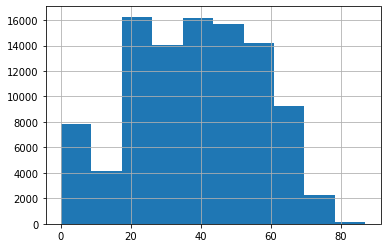

In [123]:
train.Age.hist()

In [124]:
from sklearn.preprocessing import KBinsDiscretizer

#DISCRETIZATION of Age and Fare
enc = KBinsDiscretizer(n_bins=10, encode='onehot')
enc = enc.fit(train['Age'].to_numpy().reshape(-1, 1))
Age_discretized_train = enc.transform(train['Age'].to_numpy().reshape(-1, 1))
Age_discretized_test = enc.transform(test['Age'].to_numpy().reshape(-1, 1))
# print(Age_discretized_train)

#Fare we are going to separate at intervals because there is high concentration in a region,
#and log because Fare has an asymmetric distribution 
before_normalization_train_fare = train['Fare'].copy()
train['Fare'] = np.log(train['Fare'])
test['Fare'] = np.log(test['Fare'])
enc = KBinsDiscretizer(n_bins=20, encode='onehot')
enc = enc.fit(train['Fare'].to_numpy().reshape(-1, 1))
Fare_discretized_train = enc.transform(train['Fare'].to_numpy().reshape(-1, 1))
Fare_discretized_test = enc.transform(test['Fare'].to_numpy().reshape(-1, 1))


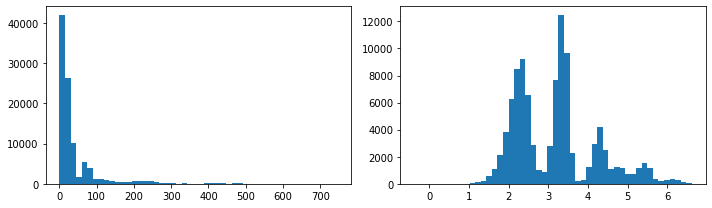

In [125]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axes[0].hist(before_normalization_train_fare, bins=50)
axes[1].hist(train["Fare"], bins=50)
fig.tight_layout()

plt.show()


In [126]:
from sklearn.preprocessing import *
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked']
cat = train[categorical_features]
cat_t = test[categorical_features]
onehotencoder = OneHotEncoder()
X = onehotencoder.fit_transform(cat).toarray()
Xt =  onehotencoder.fit_transform(cat_t).toarray()

In [132]:
X = np.concatenate([X, Age_discretized_train.toarray(), Fare_discretized_train.toarray()], axis=1)
Xt = np.concatenate((Xt, Age_discretized_test.toarray(), Fare_discretized_test.toarray()), axis=1)

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

model = LinearRegression()
model.fit(X_train, y_train)
yp = model.predict(X_train)

print(mean_squared_error(yp, y_train))
best_mse = 10000
best_i = 0
for i in range(2000):
    yp1 = yp > i/1000
    r = mean_squared_error(yp1, y_train)
    if r < best_mse:
        best_mse = r
        best_i = i
        # print(best_mse)
print(best_mse)
print(best_i)
yp1 = yp > best_i/1000
print(accuracy_score(y_train, yp1))
yp = model.predict(X_test)

print(mean_squared_error(yp, y_test))
yp1 = yp > best_i/1000
print(mean_squared_error(yp1, y_test))
print(accuracy_score(y_test, yp1))

0.15810725000575185
0.2229875
481
0.7770125
0.15825847995877265
0.22445
0.77555


In [135]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import TheilSenRegressor, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBClassifier
acc_train = []
acc_test = []


In [137]:
# model = XGBClassifier(learning_rate=0.05 + 4*0.01)
model = XGBClassifier(n_jobs=-1)
model.fit(X, y)

yp = model.predict(Xt)

with open('pred.csv', 'w') as out, open('/kaggle/input/tabular-playground-series-apr-2021/test.csv') as inp:
    out.write('PassengerId,Survived\n')
    inp.readline()
    for v in yp:
        line = inp.readline().split(",")[0]
        out.write(line + "," + str(int(v)) + "\n")

[21:24:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import TheilSenRegressor, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from xgboost import XGBClassifier
acc_train = []
acc_test = []

# model = XGBClassifier(learning_rate=0.5)


model = XGBClassifier(base_score=0.1, gamma=1, min_child_weight=3, max_depth=5, n_jobs=-1)
model.fit(X_train, y_train)
yp = model.predict(X_train)
acc_train = accuracy_score(yp, y_train)

yp = model.predict(X_test)
acc_test = accuracy_score(yp, y_test)

print(acc_train)
print(acc_test)
